# Análise Manual dos Dados

Aqui exploramos os dados de forma mais direcionada, avaliando
estatísticas descritivas, valores ausentes e distribuições relevantes.


In [1]:
import pandas as pd

# Carregar dados unificados
df = pd.read_parquet("../data/processed/df_mgsprj.parquet")

In [2]:
# Shape e informações gerais
print("Shape:", df.shape)
df.info()

Shape: (3619487, 39)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3619487 entries, 0 to 3619486
Data columns (total 39 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   sintomas                           object 
 1   profissionalsaude                  object 
 2   racacor                            object 
 3   outrossintomas                     object 
 4   profissionalseguranca              object 
 5   condicoes                          object 
 6   sexo                               object 
 7   estado                             object 
 8   estadoibge                         object 
 9   municipio                          object 
 10  municipioibge                      object 
 11  origem                             object 
 12  estadonotificacao                  object 
 13  municipionotificacao               object 
 14  municipionotificacaoibge           float64
 15  evolucaocaso                       object 
 1

In [3]:
# Valores ausentes
df.isna().mean().sort_values(ascending=False).head(30)

condicoes                        0.881635
outrossintomas                   0.811400
dataencerramento                 0.504175
classificacaofinal               0.500886
evolucaocaso                     0.494949
datasegundadose                  0.367992
lotesegundadose                  0.359665
codigolaboratoriosegundadose     0.359659
dataprimeiradose                 0.325915
loteprimeiradose                 0.318173
codigolaboratorioprimeiradose    0.318159
codigofabricanteteste1           0.313626
codigodosesvacina                0.286879
idade                            0.263978
codigoresultadoteste1            0.213883
datacoletateste1                 0.181767
datainiciosintomas               0.168762
codigotipoteste1                 0.137139
codigoestadoteste1               0.137137
municipionotificacaoibge         0.027424
estadonotificacaoibge            0.027334
codigoestrategiacovid            0.025263
codigolocalrealizacaotestagem    0.025260
municipioibge                    0

## Verificação de Colunas

Nesta etapa, verificamos se algumas variáveis possuem apenas **um valor único** em todo o conjunto de dados.  
Outras situações também podem ser avaliadas


In [4]:
print("=== Inspeção Geral de Colunas ===")

for col in df.columns:
    nun = df[col].nunique(dropna=True)
    tipo = df[col].dtype
    print(f"\n[{col}]  tipo={tipo}  (nunique={nun})")

    # Mostra os 10 valores mais comuns
    print(df[col].value_counts(dropna=False).head(10))


=== Inspeção Geral de Colunas ===

[sintomas]  tipo=object  (nunique=7035)
sintomas
Assintomático                                    625961
Outros                                           122227
Coriza, Tosse                                    118011
Tosse                                             98895
Coriza, Dor de Cabeça, Tosse                      81440
Coriza, Tosse, Febre                              73706
Coriza                                            67684
Tosse, Febre                                      60628
Coriza, Tosse, Dor de Garganta                    54524
Coriza, Dor de Cabeça, Tosse, Dor de Garganta     54450
Name: count, dtype: int64

[profissionalsaude]  tipo=object  (nunique=2)
profissionalsaude
Não     3561208
Sim       58222
None         57
Name: count, dtype: int64

[racacor]  tipo=object  (nunique=7)
racacor
Branca      1577605
Parda        888674
Ignorado     818857
Preta        173354
Amarela      157176
Indigena       2661
None           1159
Branco

In [ ]:
cols_drop = ["validado", "excluido", "source_id", 'municipioibge','origem', 'estadoibge']

df_reduzido = df.drop(columns=cols_drop, errors="ignore")
df_reduzido.shape

(3619487, 34)

In [ ]:
#fazer as codificações manuais conforme análise anterior

In [6]:
#mapear alguns valores categóricos para numéricos
map_binario = {"Sim": 1, "Não": 0}

map_sexo = {
    "Masculino": 1,
    "Feminino": 0
}

df_cod = df.copy()
# Binário
for col in ["profissionalsaude", "profissionalseguranca", "codigorecebeuvacina"]:
    if col in df_cod.columns:
        df_cod[col] = df_cod[col].map(map_binario)

# Sexo
if "sexo" in df_cod.columns:
    df_cod["sexo"] = df_cod["sexo"].map(map_sexo)

df_cod["sexo"].value_counts(dropna=False)

sexo
0.0    2176236
1.0    1443242
NaN          9
Name: count, dtype: int64

In [7]:
df_cod = df_cod.dropna(subset=["sexo"])
df_cod.shape #importante verificar se a remoção de NaN removeu corretamente as linhas com NaN em 'sexo'

(3619478, 39)

In [9]:
#filtrar apenas registros com evolução preenchida (recorte escolhido)
df_com_evolucao = df_cod.dropna(subset=["evolucaocaso"])
print("Shape com evolução:", df_com_evolucao.shape)


Shape com evolução: (1828016, 39)


In [10]:
print("\nDistribuição - Evolução do caso:")
display(df_com_evolucao["evolucaocaso"].value_counts())
#será se é possível prever os casos de óbito? Aqui já se vê que é um problema de classes desbalanceadas.


Distribuição - Evolução do caso:


evolucaocaso
Cura                        1435746
Ignorado                     275091
Em tratamento domiciliar      69220
Cancelado                     42692
Internado                      2816
Óbito                          1876
Internado em UTI                575
Name: count, dtype: int64

In [ ]:
df_com_evolucao["classificacaofinal"].value_counts(dropna=False)
#casos de óbitos por Covid-19?

classificacaofinal
Descartado                           840814
Confirmado Laboratorial              477648
Síndrome Gripal Não Especificada     425675
None                                  43541
Confirmado Clínico-Epidemiológico     24424
Confirmado por Critério Clínico       15318
Confirmado Clínico-Imagem               605
Name: count, dtype: int64

In [11]:
# Trabalhar apenas com registros que têm evolução preenchida

# Definir categorias de confirmados
confirmados_labels = [
    "Confirmado Laboratorial",
    "Confirmado Clínico-Epidemiológico",
    "Confirmado por Critério Clínico",
    "Confirmado Clínico-Imagem"
]

# Separar datasets
df_confirmados = df_com_evolucao[df_com_evolucao["classificacaofinal"].isin(confirmados_labels)]
df_nao_confirmados = df_com_evolucao[~df_com_evolucao["classificacaofinal"].isin(confirmados_labels)]

print("Total com evolução:", df_com_evolucao.shape)
print("Confirmados:", df_confirmados.shape)
print("Não confirmados:", df_nao_confirmados.shape)


Total com evolução: (1828016, 39)
Confirmados: (517993, 39)
Não confirmados: (1310023, 39)


##  Visualização e Interpretabilidade de Dados

**Distribuição de Idade (casos confirmados):**  
O histograma mostra picos entre os **30 e 45 anos**. Há menos registros de crianças e idosos no conjunto, 
o que pode refletir tanto características da pandemia quanto padrões de notificação, tanto de tamanho da população.


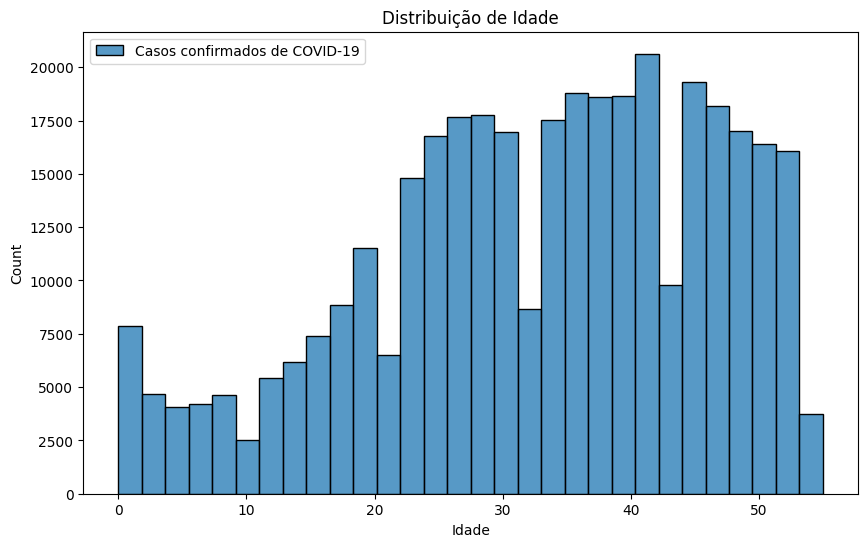

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histograma de idade dos casos confirmados
plt.figure(figsize=(10, 6))
sns.histplot(df_confirmados['idade'], bins=30)
plt.legend(["Casos confirmados de COVID-19"])  # legenda
plt.xlabel('Idade')
plt.title('Distribuição de Idade')
plt.show()


![pop.jpeg](pop.png)

A pirâmide etária do Brasil (2022) mostra que grande parte da população está entre 20-60 anos, com faixa jovem e idosa menores em proporção. Ao comparar com o histograma de casos confirmados, vemos que os casos parecem seguir essa base demográfica.

Porém certas faixas parecem subrepresentadas (ex: menos casos em idades muito baixas) — o que pode indicar vieses de testagem.

**Distribuição da Idade por Evolução do Caso de COVID-19**
O gráfico boxplot apresenta a variação da idade dos pacientes segundo a evolução do caso registrada no e-SUS Notifica. Cada caixa mostra a mediana (linha verde), os quartis (limites da caixa) e possíveis valores extremos.

<Figure size 1000x600 with 0 Axes>

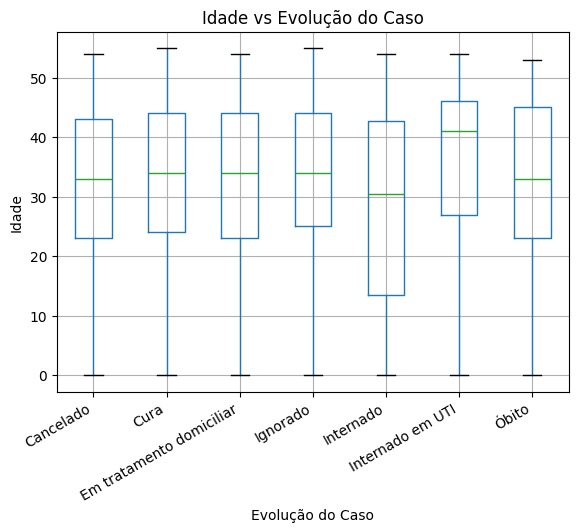

In [103]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
df_confirmados.boxplot(column="idade", by="evolucaocaso")
plt.xticks(rotation=30, ha="right")  # gira e alinha à direita
plt.title("Idade vs Evolução do Caso")
plt.suptitle("")  # remove título automático do pandas
plt.xlabel("Evolução do Caso")
plt.ylabel("Idade")
plt.show()


**Interpretação:** Observa-se que os casos de **internação em UTI** concentram-se em idades mais elevadas, 
Isso pode reforçar a maior gravidade da COVID-19 em grupos etários mais velhos.


**Sobre o boxplot:**  
O boxplot é um gráfico que resume a distribuição de uma variável numérica.  
- A linha central da caixa representa a **mediana**.  
- As bordas da caixa mostram o **1º e 3º quartil** (25% e 75% dos dados).  

- Valores muito extremos podem aparecer como **pontos isolados** (outliers).  
